In [38]:
from pathlib import Path      

In [151]:
import imp
from segment_everything.util import import_results_collection

tnia_images_path = Path(r"D:\images")
parent_path=Path(tnia_images_path / r'tnia-python-images/imagesc/2024_04_09_SAM_training')

train_dir = parent_path / 'train'

results_collection = import_results_collection(train_dir)

results_collection = results_collection[:50]
print(len(results_collection), 'files found')


50 files found


In [152]:
from segment_everything.stacked_label_dataset import StackedLabelDataset
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

dataset = StackedLabelDataset(results_collection, processor)

In [41]:
example = dataset[0]
for k,v in example.items():
  print(k,v.shape)

print()
print('original sizes', example['original_sizes'])
print('input point', example['input_points'])
print('reshaped sizes',example['reshaped_input_sizes'])

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_points torch.Size([1, 2])
ground_truth (768, 1024)

original sizes tensor([ 768, 1024])
input point tensor([[423., 257.]], dtype=torch.float64)
reshaped sizes tensor([ 768, 1024])


In [153]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset, batch_size=1, shuffle=True, drop_last=False)

In [102]:
model_type = 'vit_b'
checkpoint = 'sam_vit_b_01ec64.pth'
device = 'cuda:0'

In [103]:
from segment_anything import SamPredictor, sam_model_registry
from segment_everything.util import get_weights_path

sam_model = sam_model_registry[model_type](checkpoint=get_weights_path('vit_b'))
sam_model.to(device)
sam_model.train()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [45]:
sam_model.image_encoder.img_size

1024

In [46]:
import torch

# Set up the optimizer, hyperparameter tuning will improve performance here
lr = 0.0001
wd = 0
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()

In [156]:
from statistics import mean

from tqdm import tqdm
from torch.nn.functional import threshold, normalize
from segment_anything.utils.transforms import ResizeLongestSide
transform = ResizeLongestSide(sam_model.image_encoder.img_size)

num_epochs = 100
losses = []

for epoch in range(num_epochs):
    print('epoch', epoch)

    epoch_losses = []
    for batch in train_dataloader:

        
        input_image = batch['pixel_values'].to(device)
        original_input_size = batch['original_sizes'][0]
        input_size = batch['reshaped_input_sizes'][0]
        #input_size = tuple(input_size)
        #print('original_image_size',original_input_size)
        #print('input_size',input_size)
        #print(input_image.shape)
        
        with torch.no_grad():
            image_embedding = sam_model.image_encoder(input_image)   

            #prompt_points = batch['input_points']
            #print('before transform',prompt_box)
            #print('after transform',box)
            points_torch = torch.as_tensor(batch['input_points'], dtype=torch.float, device=device)
            #points_torch = points_torch[None, :]
            #print('batch input points', batch['input_points'])
            #print('points_torch', points_torch)
            
            
            #points_label = torch.as_tensor(1, dtype=torch.float, device=device)
            points_label = torch.tensor([1,],device=device)
            points_label = points_label[None, :]
            #print('label', points_label)
            
            sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
            points=[points_torch,points_label],
            boxes=None,
            masks=None,
            )
        
        low_res_masks, iou_predictions = sam_model.mask_decoder(
            image_embeddings=image_embedding,
            image_pe=sam_model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False,
        )

        #print('low res masks shape',low_res_masks.shape)

        #upscaled_masks = sam_model.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)
        upscaled_masks = sam_model.postprocess_masks(low_res_masks, (768,1024), (768, 1024)).to(device)
        
        binary_mask = normalize(threshold(upscaled_masks, 0.0, 0))

        #binary_mask = normalize(threshold(low_res_masks, 0.0, 0))
        gt_binary_mask = batch['ground_truth'].unsqueeze(0).to(device).float()
        gt_binary_mask = torch.as_tensor(gt_binary_mask > 0, dtype=torch.float32)
        #print('upscaled masks size', upscaled_masks.size())
        #print('binary mask size',binary_mask.size())
        #print('gt_binary_mask size',gt_binary_mask.size())
        #print('image min max', input_image.max(), input_image.min())
        #print('binary min max',binary_mask.max(), binary_mask.min())
        #print('gt_min_max',gt_binary_mask.max(), gt_binary_mask.min())
        #print()
        #print('gt_binary_mask shape',gt_binary_mask.shape)

        #loss = loss_fn(upscaled_masks, gt_binary_mask)
        loss = loss_fn(binary_mask, gt_binary_mask)
        optimizer.zero_grad()

        #print(loss)

        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())

        '''
        for name, param in sam_model.named_parameters():
            if param.grad is not None:
                print(f"Gradient norm of {name}: {param.grad.norm().item()}")
        '''
    losses.append(epoch_losses)
    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
        
        
    
        
        

    #ground_truth_mask = batch['ground_truth_mask'].to(device)

 

epoch 0
EPOCH: 0
Mean loss: 0.017541021384531633
epoch 1
EPOCH: 1
Mean loss: 0.014367243893211708
epoch 2
EPOCH: 2
Mean loss: 0.01880597509909421
epoch 3
EPOCH: 3
Mean loss: 0.01630439793691039
epoch 4
EPOCH: 4
Mean loss: 0.01556343107833527
epoch 5
EPOCH: 5
Mean loss: 0.018289210560033096
epoch 6
EPOCH: 6
Mean loss: 0.02283129432820715
epoch 7
EPOCH: 7
Mean loss: 0.020584641047753392
epoch 8
EPOCH: 8
Mean loss: 0.01837051447830163
epoch 9
EPOCH: 9
Mean loss: 0.021216151771368458
epoch 10
EPOCH: 10
Mean loss: 0.01852582342340611
epoch 11
EPOCH: 11
Mean loss: 0.016604970900225453
epoch 12
EPOCH: 12
Mean loss: 0.020547816527541726
epoch 13
EPOCH: 13
Mean loss: 0.021613820873899386
epoch 14
EPOCH: 14
Mean loss: 0.016508611619938166
epoch 15
EPOCH: 15
Mean loss: 0.02100201989989728
epoch 16
EPOCH: 16
Mean loss: 0.017511546385940165
epoch 17
EPOCH: 17
Mean loss: 0.022561798868700862
epoch 18
EPOCH: 18
Mean loss: 0.012872823438374325
epoch 19
EPOCH: 19
Mean loss: 0.015271937579382212
epoch 2

In [159]:
import torch

# Save the model's state dictionary to a file
torch.save(sam_model.state_dict(), parent_path / "mito_model_checkpoint3.pth")

tensor([[[499., 702.]]], device='cuda:0')


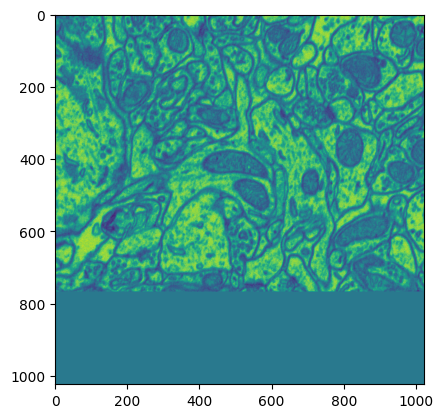

In [160]:
import matplotlib.pyplot as plt

input_image_ = input_image.squeeze(0).cpu().numpy()
input_image_ = input_image_.mean(axis=0)
plt.imshow(input_image_)
input_image_.min(), input_image_.max()
print(points_torch)

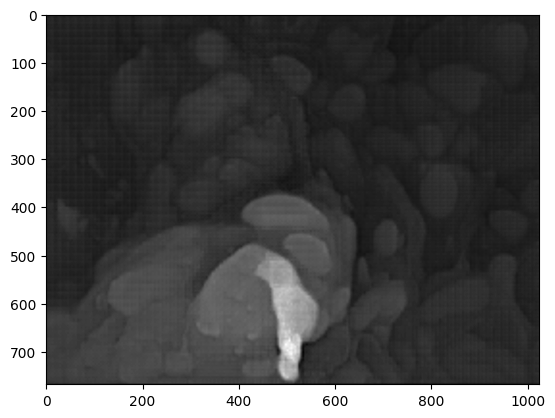

(-4.189903, 4.7440224)

In [161]:
# convert binary mask to numpy
binary_mask_ = upscaled_masks.detach().cpu().numpy()
gt_binary_mask_ = gt_binary_mask.detach().cpu().numpy()

import matplotlib.pyplot as plt
plt.imshow(binary_mask_.squeeze(), cmap='gray')
plt.show()
binary_mask_.min(), binary_mask_.max()


(0.0, 0.0)

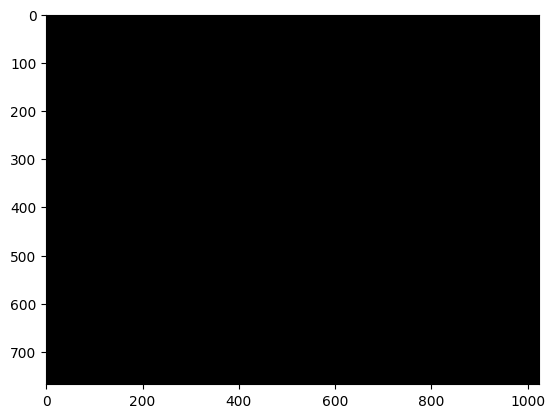

In [162]:
plt.imshow(gt_binary_mask_.squeeze(), cmap='gray')
gt_binary_mask_.min(), gt_binary_mask_.max()

In [163]:
import napari
viewer = napari.Viewer()
viewer.add_image(input_image_)
viewer.add_image(binary_mask_.squeeze(), colormap='gray')
viewer.add_image(gt_binary_mask_.squeeze(), colormap='gray')

<Image layer 'Image [1]' at 0x28e52725810>

In [164]:
from segment_anything.automatic_mask_generator import SamAutomaticMaskGenerator
from segment_anything import sam_model_registry, SamPredictor 

In [165]:
reload = False

if reload:

    import torch

    model_type = 'vit_b'
    checkpoint = 'sam_vit_b_01ec64.pth'
    device = 'cuda:0'

    from segment_anything import SamPredictor, sam_model_registry
    from segment_everything.util import get_weights_path

    sam_model = sam_model_registry[model_type](checkpoint=parent_path / "mito_model_checkpoint2.pth")
    sam_model.to(device)
    sam_model.train()

In [166]:
import numpy as np
from segment_anything import SamPredictor, sam_model_registry
test_image = results_collection[0]['image']
test_label = results_collection[0]['binary']
test_image = np.stack([test_image, test_image, test_image], axis=-1)
predictor = SamPredictor(sam_model)
#generator = SamAutomaticMaskGenerator(sam_model)
generator = SamAutomaticMaskGenerator(sam_model, points_per_batch=32, pred_iou_thresh=0.2)#, stability_score_thresh=0, box_nms_thresh=0.99, crop_nms_thresh=0.9)

(1, 256, 256) (1, 768, 1024)
[0.95341104]


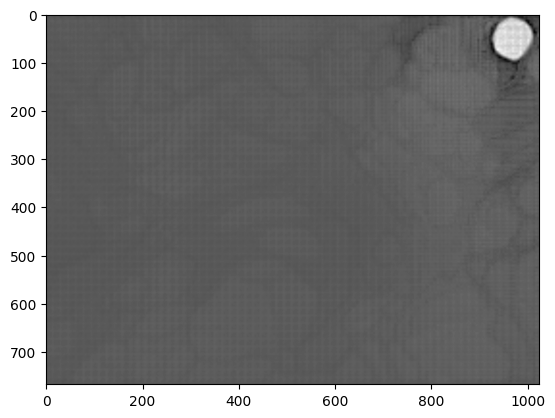

In [167]:
import matplotlib.pyplot as plt

predictor = SamPredictor(sam_model)
predictor.set_image(test_image)

points = np.array([[975,60]])
mask, feedback, logits = predictor.predict(point_coords=points, point_labels=[1], return_logits=True, multimask_output=False)

plt.imshow(mask[0,:,:], cmap='gray')

print(logits.shape, mask.shape)
print(feedback)

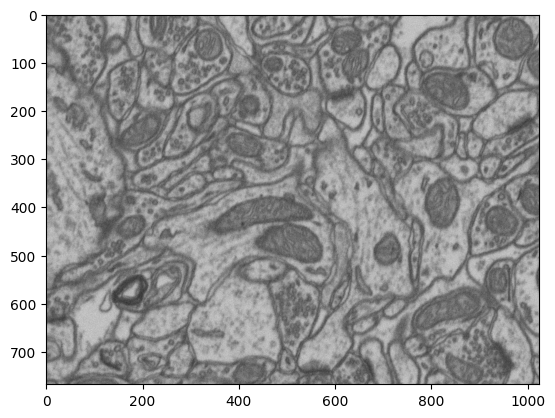

In [168]:
plt.imshow(test_image)

In [169]:
import napari
viewer = napari.Viewer()
viewer.add_image(test_image)
viewer.add_image(mask[0,:,:])
viewer.add_labels(test_label)


<Labels layer 'test_label' at 0x28e81e38040>

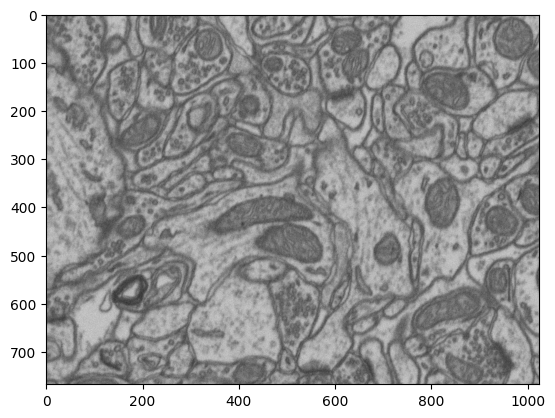

In [170]:
test_image.dtype, test_image.shape
test_image.min(), test_image.max()
plt.imshow(test_image)

In [176]:

generator = SamAutomaticMaskGenerator(sam_model, points_per_side=32, pred_iou_thresh=0.8, stability_score_thresh=0.8)
results = generator.generate(test_image)
print(len(results))

152


In [172]:
import numpy as np
generator = SamAutomaticMaskGenerator(sam_model, points_per_side=None, pred_iou_thresh=0, stability_score_thresh=0, point_grids=[np.array([[975,60]])])
result = generator.generate(test_image)
print(len(result))

3


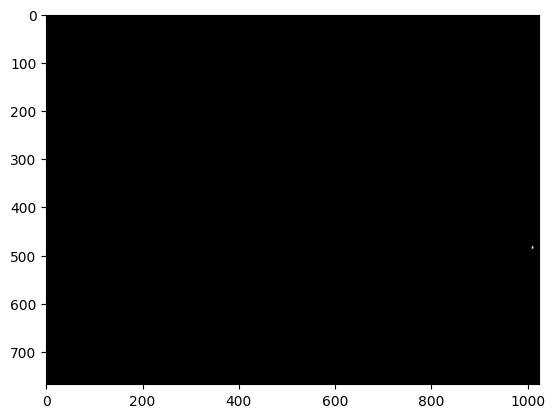

In [175]:
test = result[2]['segmentation']

plt.imshow(test, cmap='gray')

In [177]:
from tnia.deeplearning.sam_helper import make_label_image_3d
threed = make_label_image_3d(results)

In [178]:
import napari
viewer = napari.Viewer()
viewer.add_image(test_image)
viewer.add_labels(test_label)
viewer.add_labels(threed)

<Labels layer 'threed' at 0x28e8556ea70>

In [113]:
len(result)

0

In [69]:
result[0].keys() 

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])

In [92]:
for r in result:
    print(r['predicted_iou'], r['stability_score'])

0.6972388029098511 0.0009524027700535953
0.37459802627563477 0.0


In [140]:
project = {}

results = sorted(results, key=lambda x: x['area'], reverse=False)
label_num = 1

for r in results:
    r['keep'] = True
    r['label_num'] = label_num
    label_num += 1

project['results'] = results
project['image'] = test_image

In [141]:
import pickle

out_name = parent_path / 'test_trained3.pkl'

with open(out_name, 'wb') as f:
    pickle.dump(project, f)